In [8]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2
import sklearn
import pickle 

In [9]:
haar = cv2.CascadeClassifier("./model/haarcascade_frontalface_default.xml")
pca_dict = pickle.load(open("./model/pca_dict.pickle" , mode = 'rb'))
pca_model = pca_dict['pca']
mean_face = pca_dict['mean_face']
mean_face = mean_face.values
svm_model = pickle.load(open("./model/model_svm.pickle" , mode = 'rb'))


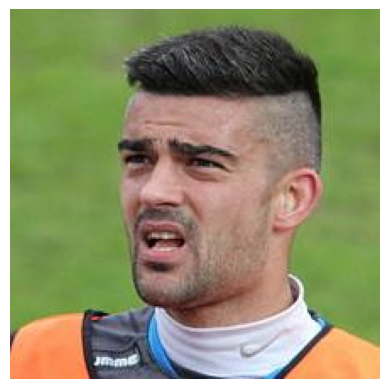

In [21]:
# Load the test image

image = cv2.imread("./prediction_images/male_000018.jpg")
img_rgb = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

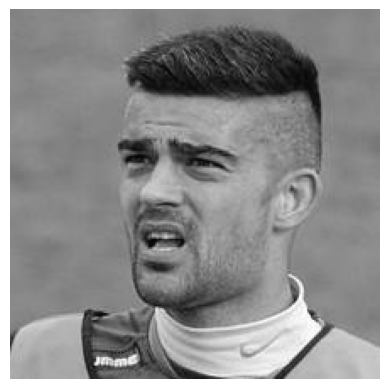

In [11]:
plt.imshow(gray ,cmap = 'gray')
plt.axis('off')
plt.show()

Creating the pipeline for predictions on new data:

Step1. Load the models : haar cascade classifier , mean_face_pixel_data , pca_model , svm_model


Step2. load the image for prediction


Step3. convert the image to gray cmap and single channel 


Step4. use the haar cascade classifier on the image to get the face pointers (x,y, w, h)


Step5. Get the cropped face using the face pointers from the image 


Step6. Normalize the cropped faces : divide by 255


Step7. reshape the cropped face/faces to (100,100)


Step8. flatten the cropped face/faces and subtract mean face pixels from it/them 


Step9. Give the transformed flattened face/faces data to pca_model to get the eigen faces(the directions capturing the max variance in data)


Step10. Use pca_model to get the inverse_transform of the eigen_face : needed for visualization


Step11. Use the svm_model on the eigen face data to get the gender prediction . Also get the probability score using predict_proba and then get maxProbability for face/faces


Step12. Define the different colors for male and female . Use those colors on the rectangle margins of the faces detected in the image


Step13. Also put the text giving gender and probability for the specific gender prediction.


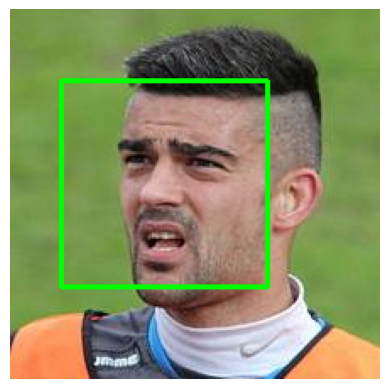

In [22]:
# Visualization of the face detection

faces = haar.detectMultiScale(gray , scaleFactor=1.5 , minNeighbors=3)
for x,y,w,h in faces:
    cv2.rectangle(img_rgb , (x,y) , (x+w , y+h) , (0,255,0) , 2)

plt.imshow(img_rgb)
plt.axis('off')
plt.show()

In [14]:
mean_face = mean_face.reshape((1,10000))

In [15]:
mean_face

array([[0.3805436 , 0.37781036, 0.3745058 , ..., 0.38266946, 0.38324479,
        0.38488105]], shape=(1, 10000))

male : 98.05%


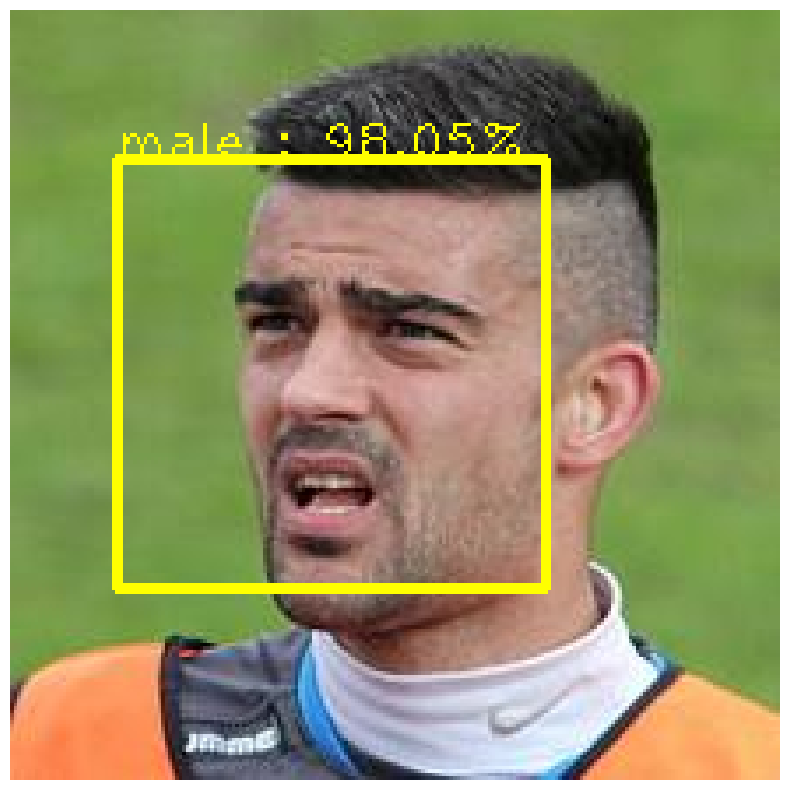

In [23]:

faces = haar.detectMultiScale(gray , scaleFactor=1.5 , minNeighbors=3)
predictions = []
for x , y , w , h in faces :
    roi = gray[y:y+h , x : x+w]
    roi = roi / 255.0
    if roi.shape[0] > 100:
        roi_resize = cv2.resize(roi , (100,100), interpolation=cv2.INTER_AREA)
    elif roi.shape[0] < 100:
        roi_resize = cv2.resize(roi , (100,100), interpolation=cv2.INTER_CUBIC)

    else:
        roi_resize = roi 

    flatten = roi_resize.reshape((1,10000))

    # Subtract from the mean face 

    roi_mean = flatten - mean_face 

    # Get Eigen Image 
    roi_mean = pd.DataFrame(roi_mean , columns = [f"pixel_{i}" for i in range(10000)])

    eigen_image = pca_model.transform(roi_mean)

    # Inverse transform 

    eigen_inverse = pca_model.inverse_transform(eigen_image)

    
    # Get the model prediction 

    gender = svm_model.predict(eigen_image)
    prediction_probability = svm_model.predict_proba(eigen_image)
    gender_probability = prediction_probability.max()

    print(f'{gender[0]} : {np.round(gender_probability*100,2)}%')

    text = f"{gender[0]} : {np.round(gender_probability*100 , 2)}%"

    # Defining different colors for the genders
    if gender[0] == 'male':
        color = (255,255,0)
    else:
        color = (255,0,255)

    cv2.rectangle(img_rgb , (x,y) , (x+w , y+h) , color , 2)

    
    cv2.putText(img_rgb , text  , (x,y) , fontFace = cv2.FONT_HERSHEY_PLAIN , fontScale=1 , color = color , thickness = 1 )

    output = {"roi":roi , "eigen_image" : eigen_image,"eig_inverse":eigen_inverse , 'gender_prediction':gender , "prediction_prob" : gender_probability}

    predictions.append(output)

plt.figure(figsize = (10,10))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()






    

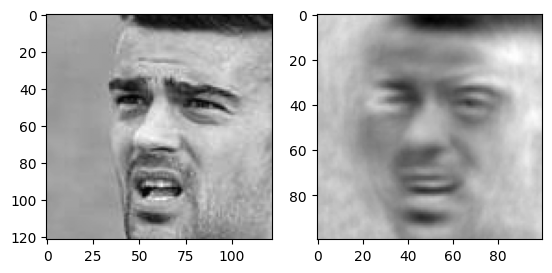

In [25]:
for i in range(len(predictions)):
    face_gray = predictions[i]['roi']
    face_eigen_inv = predictions[i]['eig_inverse']
    face_eigen_inv = face_eigen_inv.reshape((100,100))
    plt.subplot(1,2,1)
    plt.imshow(face_gray , cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(face_eigen_inv , cmap = 'gray')

    plt.show()
